In [ ]:
import os
os.environ['TEJAPI_KEY'] = "Yourkey"
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
import TejToolAPI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import alphalens
from zipline.pipeline import Pipeline
from logbook import Logger, StderrHandler, INFO

c:\Users\bca5j\anaconda3\envs\kebulin\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\bca5j\anaconda3\envs\kebulin\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\bca5j\anaconda3\envs\kebulin\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

In [3]:
from zipline.sources.TEJ_Api_Data import get_universe
start = '2020-01-01'
end = '2023-12-31'
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e =['Common Stock-Foreign', 'Common Stock'])
pool[:10]

[2024-11-08 07:49:33.471075]: INFO: get_universe_TW: Filters：{'mkt': ['TWSE', 'OTC'], 'stktp_e': ['Common Stock-Foreign', 'Common Stock']}


Currently used TEJ API key call quota 499/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 21250323/9223372036854775807 (0.0%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210']

In [4]:
start_dt = pd.Timestamp(start, tz='utc')
end_dt = pd.Timestamp(end, tz='utc')

tickers = ' '.join(pool)

fields = ''
columns = ['fld005','fld005l']
# Director_and_Supervisor_Holdings_Percentage = fld005 請見 TQuant 資料集

fields = ' '.join(columns)

os.environ['mdate'] = start+' '+end
os.environ['ticker'] = tickers+' IR0001'
os.environ['fields'] = fields

In [5]:
!zipline ingest -b tquant

^C


In [6]:
!zipline ingest -b fundamentals

Currently used TEJ API key call quota 621/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 26798137/9223372036854775807 (0.0%)


[2024-11-08 07:53:23.127829] INFO: zipline.data.bundles.core: Ingesting fundamentals.
[2024-11-08 07:54:45.147475] INFO: zipline.data.bundles.core: Ingest fundamentals successfully.


In [7]:
data = TejToolAPI.get_history_data(ticker=pool, columns=columns, transfer_to_chinese=False, start = start, end = end)
data = data.sort_values(['coid','mdate'])
data

Merging daily equity files:
Currently used TEJ API key call quota 667/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 26956591/9223372036854775807 (0.0%)


[2024-11-08 07:49:50.522405] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-11-08 07:55:04.415002] INFO: zipline.data.bundles.core: Ingest tquant successfully.


Currently used TEJ API key call quota 737/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 28908777/9223372036854775807 (0.0%)


,coid,mdate,Director_and_Supervisor_Holdings_Percentage,Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period
0,1101,2020-01-02,14.32,0.00
1,1101,2020-01-03,14.32,0.00
2,1101,2020-01-06,14.32,0.00
3,1101,2020-01-07,14.32,0.00
4,1101,2020-01-08,14.32,0.00
...,...,...,...,...
1707386,9962,2023-12-25,13.45,0.01
1707387,9962,2023-12-26,13.45,0.01
1707388,9962,2023-12-27,13.45,0.01
1707389,9962,2023-12-28,13.45,0.01


In [8]:
from zipline.data.data_portal import get_bundle
from zipline.data import bundles

bundle = bundles.load('tquant')


df_bundle = get_bundle(bundle_name='tquant',
                        calendar_name='TEJ',
                        start_dt=start_dt,
                        end_dt=end_dt)
df_bundle

,date,sid,symbol,asset,open,high,low,close,volume,open_adj,...,close_adj,volume_adj,dividend_payouts.amount,dividend_payouts.declared_date,dividend_payouts.div_percent,dividend_payouts.pay_date,dividend_payouts.record_date,dividends.ratio,splits.ratio,mergers.ratio
0,2020-01-02 00:00:00+00:00,0,1101,Equity(0 [1101]),43.80,44.15,43.80,44.10,1.847000e+07,32.273,...,32.494,2.132989e+07,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1,2020-01-02 00:00:00+00:00,1,1102,Equity(1 [1102]),48.10,49.00,48.05,48.90,8.890000e+06,36.781,...,37.393,8.890000e+06,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
2,2020-01-02 00:00:00+00:00,2,1103,Equity(2 [1103]),22.40,22.70,22.35,22.35,2.194000e+06,18.453,...,18.412,2.238666e+06,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
3,2020-01-02 00:00:00+00:00,3,1104,Equity(3 [1104]),19.60,19.70,19.55,19.65,8.670000e+05,15.566,...,15.606,8.931635e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
4,2020-01-02 00:00:00+00:00,4,1108,Equity(4 [1108]),8.38,8.45,8.28,8.37,3.100000e+05,7.046,...,7.037,3.100000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817479,2023-12-29 00:00:00+00:00,1861,9955,Equity(1861 [9955]),24.70,24.70,24.40,24.40,2.520000e+05,24.700,...,24.400,2.520000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1817480,2023-12-29 00:00:00+00:00,1862,9958,Equity(1862 [9958]),173.50,175.50,172.00,174.50,2.726000e+06,173.500,...,174.500,2.726000e+06,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1817481,2023-12-29 00:00:00+00:00,1863,9960,Equity(1863 [9960]),27.40,27.45,27.20,27.45,1.600000e+04,27.400,...,27.450,1.600000e+04,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN
1817482,2023-12-29 00:00:00+00:00,1864,9962,Equity(1864 [9962]),18.30,18.30,18.05,18.25,4.080000e+05,18.300,...,18.250,4.080000e+05,NaN,NaT,NaN,NaT,NaT,NaN,NaN,NaN


In [9]:
from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    
    Director_and_Supervisor_Holdings_Percentage = Column(dtype=float)
    
    domain = TW_EQUITIES

In [10]:
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

transform_data = data.set_index(['coid', 'mdate']).unstack('coid')
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data

Director_and_Supervisor_Holdings_Percentage         \
coid                                                             0      1      
mdate                                                                          
2020-01-02 00:00:00+00:00                                       14.32  29.01   
2020-01-03 00:00:00+00:00                                       14.32  29.01   
2020-01-06 00:00:00+00:00                                       14.32  29.01   
2020-01-07 00:00:00+00:00                                       14.32  29.01   
2020-01-08 00:00:00+00:00                                       14.32  29.01   
...                                                               ...    ...   
2023-12-25 00:00:00+00:00                                        7.48  27.46   
2023-12-26 00:00:00+00:00                                        7.48  27.46   
2023-12-27 00:00:00+00:00                                        7.48  27.46   
2023-12-28 00:00:00+00:00                                        7.48  27.46   
2023-12-29 00:00:00+00:00                                        7.48  27.46   

                                                                           \
coid                        2      3     4      5      6      7      8      
mdate                                                                       
2020-01-02 00:00:00+00:00  17.11  24.13  3.95  41.75  33.56  14.55  28.48   
2020-01-03 00:00:00+00:00  17.11  24.13  3.95  41.75  33.56  14.55  28.48   
2020-01-06 00:00:00+00:00  17.11  24.13  3.95  41.75  33.56  14.55  28.48   
2020-01-07 00:00:00+00:00  17.11  24.13  3.95  41.75  33.56  14.55  28.48   
2020-01-08 00:00:00+00:00  17.11  24.13  3.95  41.75  33.56  14.55  28.48   
...                          ...    ...   ...    ...    ...    ...    ...   
2023-12-25 00:00:00+00:00  17.15  24.14  3.95  36.37  31.40  14.55  28.84   
2023-12-26 00:00:00+00:00  17.15  24.14  3.95  36.37  31.40  14.55  28.84   
2023-12-27 00:00:00+00:00  17.15  24.14  3.95  36.37  31.40  14.55  28.84   
2023-12-28 00:00:00+00:00  17.15  24.14  3.95  36.37  31.40  14.55  28.84   
2023-12-29 00:00:00+00:00  17.15  24.14  3.95  36.37  31.40  14.55  28.84   

                                  ...  \
coid                        9     ...   
mdate                             ...   
2020-01-02 00:00:00+00:00  12.69  ...   
2020-01-03 00:00:00+00:00  12.69  ...   
2020-01-06 00:00:00+00:00  12.69  ...   
2020-01-07 00:00:00+00:00  12.69  ...   
2020-01-08 00:00:00+00:00  12.69  ...   
...                          ...  ...   
2023-12-25 00:00:00+00:00  13.00  ...   
2023-12-26 00:00:00+00:00  13.00  ...   
2023-12-27 00:00:00+00:00  13.00  ...   
2023-12-28 00:00:00+00:00  13.00  ...   
2023-12-29 00:00:00+00:00  13.00  ...   

                          Difference_in_Director_and_Supervisor_Holdings_Percentage_from_Previous_Period  \
coid                                                                                                1855   
mdate                                                                                                      
2020-01-02 00:00:00+00:00                                               0.02                               
2020-01-03 00:00:00+00:00                                               0.02                               
2020-01-06 00:00:00+00:00                                               0.02                               
2020-01-07 00:00:00+00:00                                               0.02                               
2020-01-08 00:00:00+00:00                                               0.02                               
...                                                                      ...                               
2023-12-25 00:00:00+00:00                                               0.00                               
2023-12-26 00:00:00+00:00                                               0.00                               
2023-12-27 00:00:00+00:00                                      

In [11]:
from zipline.pipeline.loaders.frame import DataFrameLoader

inputs=[CustomDataset.Director_and_Supervisor_Holdings_Percentage
        ]
        
Custom_loader = {i:DataFrameLoader(column=i, baseline=transform_data[i.name]) for i in inputs}
Custom_loader

{CustomDataset<TW>.Director_and_Supervisor_Holdings_Percentage::float64: <zipline.pipeline.loaders.frame.DataFrameLoader at 0x1d9663c5bd0>}

In [12]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.loaders import EquityPricingLoader
pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader,
                                                bundle.adjustment_reader)
def choose_loader(column):
    if column.name in EquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:     
        return Custom_loader[column]
    else:
        raise Exception('Column not available')
    
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle.asset_finder,
                              default_domain = TW_EQUITIES)

In [13]:
from zipline.pipeline.data import TQDataSet, TQAltDataSet, EquityPricing
from zipline.pipeline.factors import DailyReturns

def compute_signals():
    
    Dire = CustomDataset.Director_and_Supervisor_Holdings_Percentage.latest

    return Pipeline(columns={
        'Dire':Dire,
        'longs' : Dire.top(30),
        },
    )

In [14]:
from zipline.TQresearch.tej_pipeline import run_pipeline
pipeline_result = engine.run_pipeline(compute_signals(), start, end)
pipeline_result

Dire  longs
2020-01-03 00:00:00+00:00 Equity(0 [1101])       14.32  False
                          Equity(1 [1102])       29.01  False
                          Equity(2 [1103])       17.11  False
                          Equity(3 [1104])       24.13  False
                          Equity(4 [1108])        3.95  False
...                                                ...    ...
2023-12-29 00:00:00+00:00 Equity(1861 [9955])    39.16  False
                          Equity(1862 [9958])    18.14  False
                          Equity(1863 [9960])    14.03  False
                          Equity(1864 [9962])    13.45  False
                          Equity(1865 [IR0001])    NaN  False

[1706875 rows x 2 columns]

In [15]:
pipeline_result.query("longs == 1")

Dire  longs
2020-01-03 00:00:00+00:00 Equity(21 [1232])    67.93   True
                          Equity(122 [1525])   77.84   True
                          Equity(131 [1535])   68.65   True
                          Equity(235 [2007])   73.18   True
                          Equity(251 [2029])   65.76   True
...                                              ...    ...
2023-12-29 00:00:00+00:00 Equity(1755 [8418])  72.05   True
                          Equity(1778 [8455])  79.01   True
                          Equity(1785 [8473])  68.00   True
                          Equity(1810 [8931])  70.38   True
                          Equity(1843 [9930])  68.64   True

[29190 rows x 2 columns]

In [17]:
engine = SimplePipelineEngine(
    get_loader=lambda column: Custom_loader.get(column),
    asset_finder=bundle.asset_finder,
    default_domain=TW_EQUITIES
)

In [18]:
# 正式開始回測

In [19]:
# 定義再平衡日期
from zipline.utils.calendar_utils import get_calendar 
cal = get_calendar('TEJ').all_sessions

cal = cal[(cal >= '2020-01-01') & (cal <= '2023-12-31')]

cal[-10:]

DatetimeIndex(['2023-12-18 00:00:00+00:00', '2023-12-19 00:00:00+00:00',
               '2023-12-20 00:00:00+00:00', '2023-12-21 00:00:00+00:00',
               '2023-12-22 00:00:00+00:00', '2023-12-25 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='C')

In [20]:
cal = pd.DataFrame(cal).rename(columns={0:'date'})

cal['diff'] = cal['date'].transform(lambda x: x - pd.Timestamp(year=x.year, month=x.month, day=15, tz='UTC'))

cal.tail(10)

,date,diff
964,2023-12-18 00:00:00+00:00,3 days
965,2023-12-19 00:00:00+00:00,4 days
966,2023-12-20 00:00:00+00:00,5 days
967,2023-12-21 00:00:00+00:00,6 days
968,2023-12-22 00:00:00+00:00,7 days
969,2023-12-25 00:00:00+00:00,10 days
970,2023-12-26 00:00:00+00:00,11 days
971,2023-12-27 00:00:00+00:00,12 days
972,2023-12-28 00:00:00+00:00,13 days
973,2023-12-29 00:00:00+00:00,14 days


In [21]:
# 篩選出平衡日期 並轉為字串
tradeday = cal.groupby([cal['date'].dt.year, cal['date'].dt.month]).apply(lambda x: x[x['diff'].ge(pd.Timedelta(days=0))].head(1)).date.tolist()
tradeday = [str(i.date()) for i in tradeday]
tradeday[-5:]

['2023-08-15', '2023-09-15', '2023-10-16', '2023-11-15', '2023-12-15']

In [22]:
cal = pd.DataFrame(cal).rename(columns={0:'date'})

cal['diff'] = cal['date'].transform(lambda x: x - pd.Timestamp(year=x.year, month=x.month, day=15, tz='UTC'))

cal.tail(10)

,date,diff
964,2023-12-18 00:00:00+00:00,3 days
965,2023-12-19 00:00:00+00:00,4 days
966,2023-12-20 00:00:00+00:00,5 days
967,2023-12-21 00:00:00+00:00,6 days
968,2023-12-22 00:00:00+00:00,7 days
969,2023-12-25 00:00:00+00:00,10 days
970,2023-12-26 00:00:00+00:00,11 days
971,2023-12-27 00:00:00+00:00,12 days
972,2023-12-28 00:00:00+00:00,13 days
973,2023-12-29 00:00:00+00:00,14 days


In [23]:
def analyze(context, perf):
    
    fig = plt.figure(figsize=(16, 12))
    
    # First chart(累計報酬)
    ax = fig.add_subplot(311) 
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(True)
    
    # Second chart(ending_cash)->觀察是否超買
    ax = fig.add_subplot(312)
    ax.plot(perf['ending_cash'], 
            label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(True)

[2024-11-08 08:02:54.418560]: INFO: handle_split: after split: asset: Equity(1269 [6023]), amount: 602, cost_basis: 55.43, last_sale_price: 55.800000000000004
[2024-11-08 08:02:54.420465]: INFO: handle_split: returning cash: 52.28
[2024-11-08 08:02:54.575742]: INFO: rebalance: Cancel_order: current time: 2020-02-17 , created: 2020-01-15 , asset: Equity(1387 [6236]), amount: 3174 , filled: 0
[2024-11-08 08:02:57.207608]: INFO: earn_dividends: Equity(1798 [8908]), cash_dividend amount: 0.9, pay_date: 2020-04-29, div_owed: 586.8000000000001
[2024-11-08 08:03:01.479679]: INFO: earn_dividends: Equity(1269 [6023]), cash_dividend amount: 3.1999999999999997, pay_date: 2020-06-30, div_owed: 1996.7999999999997
[2024-11-08 08:03:01.639569]: INFO: earn_dividends: Equity(1515 [6581]), cash_dividend amount: 2.6, pay_date: 2020-07-15, div_owed: 1432.6000000000001
[2024-11-08 08:03:01.985504]: INFO: earn_dividends: Equity(1474 [6505]), cash_dividend amount: 2.9, pay_date: 2020-07-22, div_owed: 1128.1


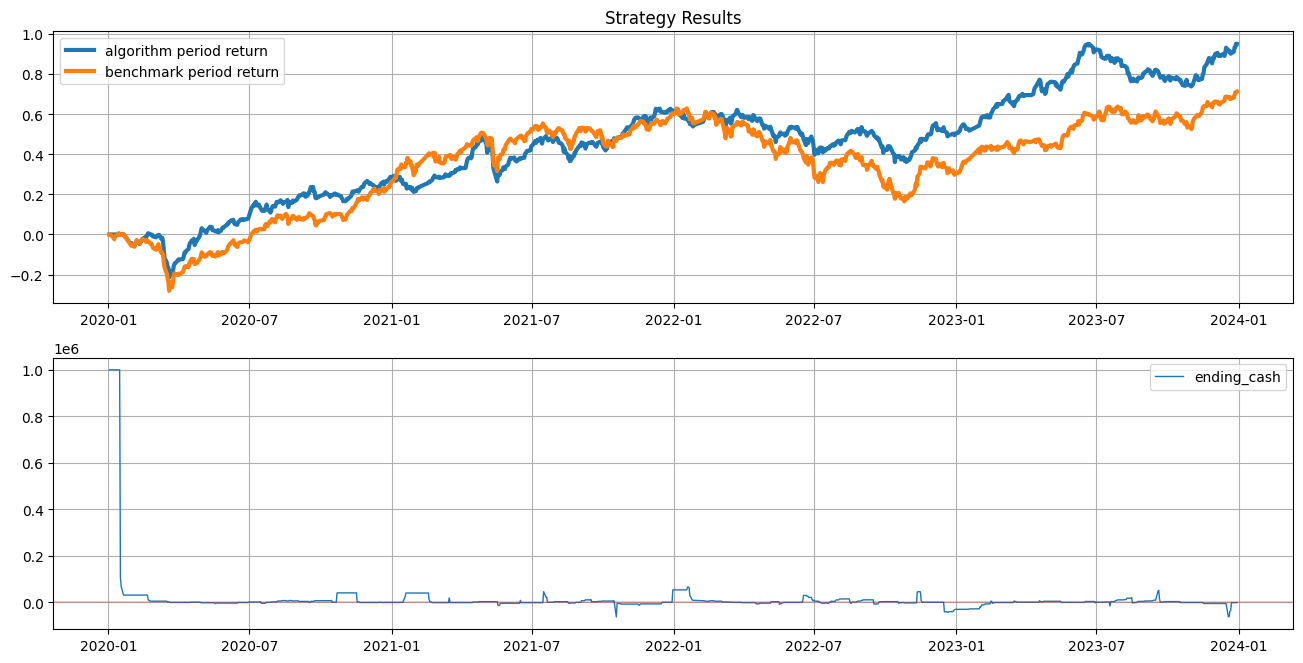

In [24]:
from zipline.algo.pipeline_algo import *

algo = TargetPercentPipeAlgo(
                     start_session=start_dt,
                     end_session=end_dt,
                     capital_base=1e6,                
                     tradeday=tradeday,
                     max_leverage=1,
                     slippage_model=slippage.VolumeShareSlippage(volume_limit=0.15, price_impact=0.01),
                     pipeline=compute_signals,
                     analyze=analyze,
                     custom_loader = Custom_loader
)

results = algo.run()

Start date,2020-01-02
End date,2023-12-29
Total months,46
,Backtest
Annual return,18.866%
Cumulative returns,95.032%
Annual volatility,14.816%
Sharpe ratio,1.24
Calmar ratio,0.86
Stability,0.84
Max drawdown,-21.948%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.95,2020-02-21,2020-03-19,2020-04-29,46
1,16.41,2021-12-13,2022-10-13,2023-02-20,287
2,15.06,2021-04-29,2021-05-17,2021-07-19,56
3,10.88,2023-06-21,2023-10-31,2023-12-28,131
4,8.41,2021-07-19,2021-08-19,2021-10-26,69


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the foll

Stress Events,mean,min,max
New Normal,0.07%,-5.85%,4.24%


Top 10 long positions of all time,max
sid,
5344,6.97%
4192,6.88%
2630,6.76%
1475,6.07%
8059,5.85%
8046,5.83%
2007,5.81%
6577,5.56%
6236,5.48%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
5344,6.97%
4192,6.88%
2630,6.76%
1475,6.07%
8059,5.85%
8046,5.83%
2007,5.81%
6577,5.56%
6236,5.48%


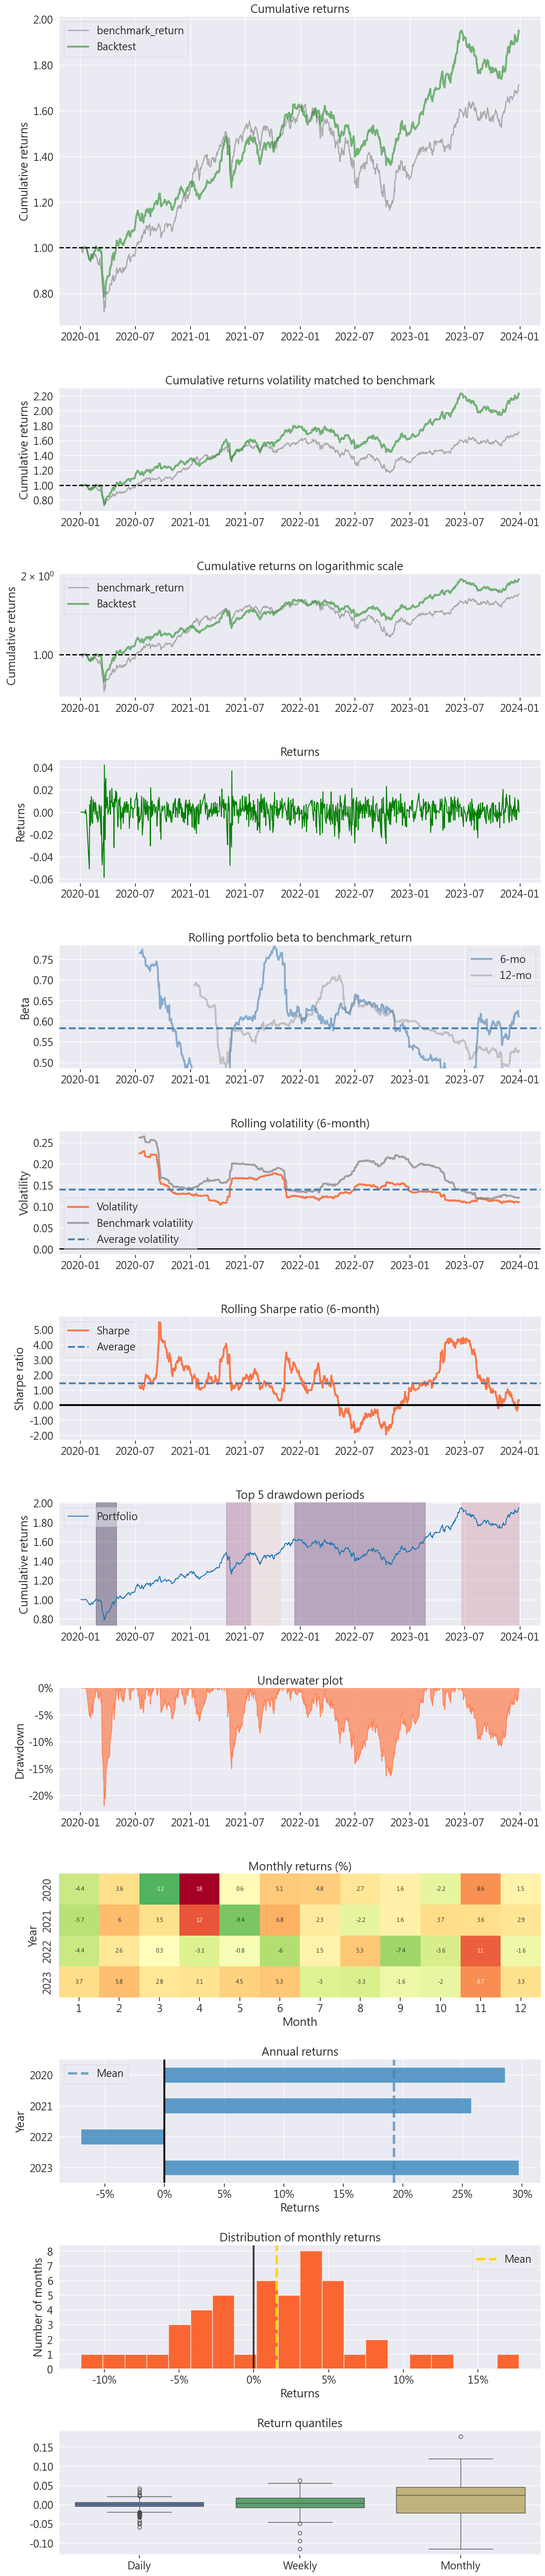

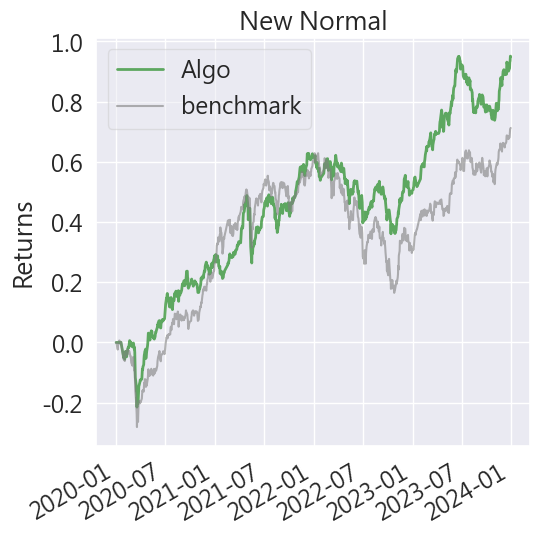

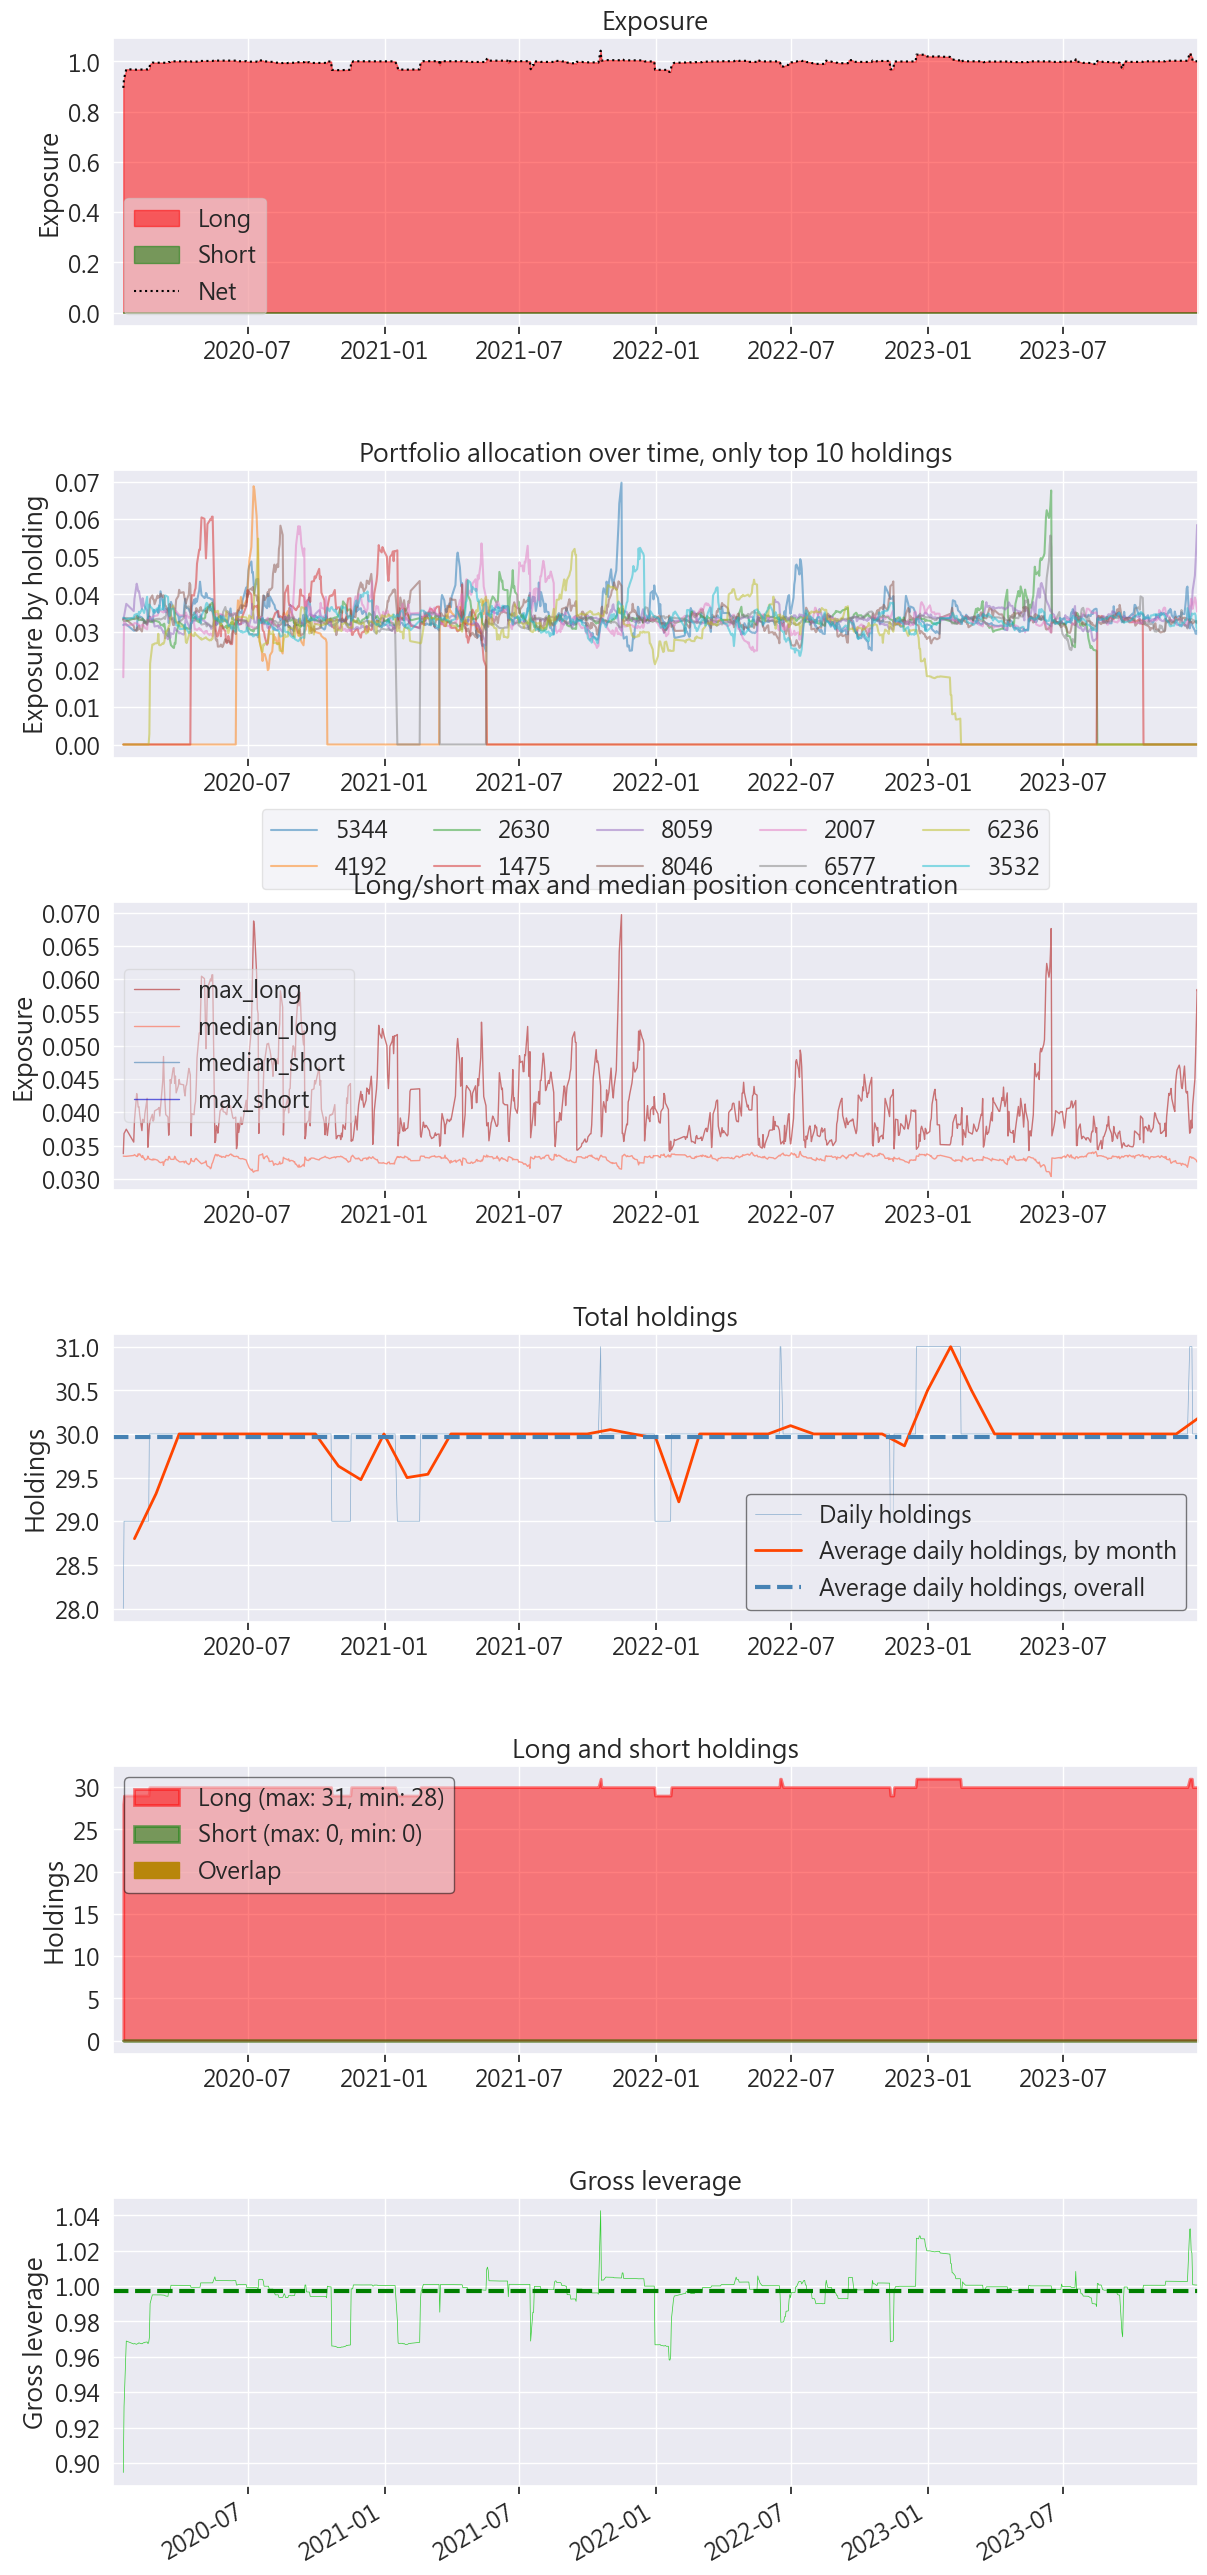

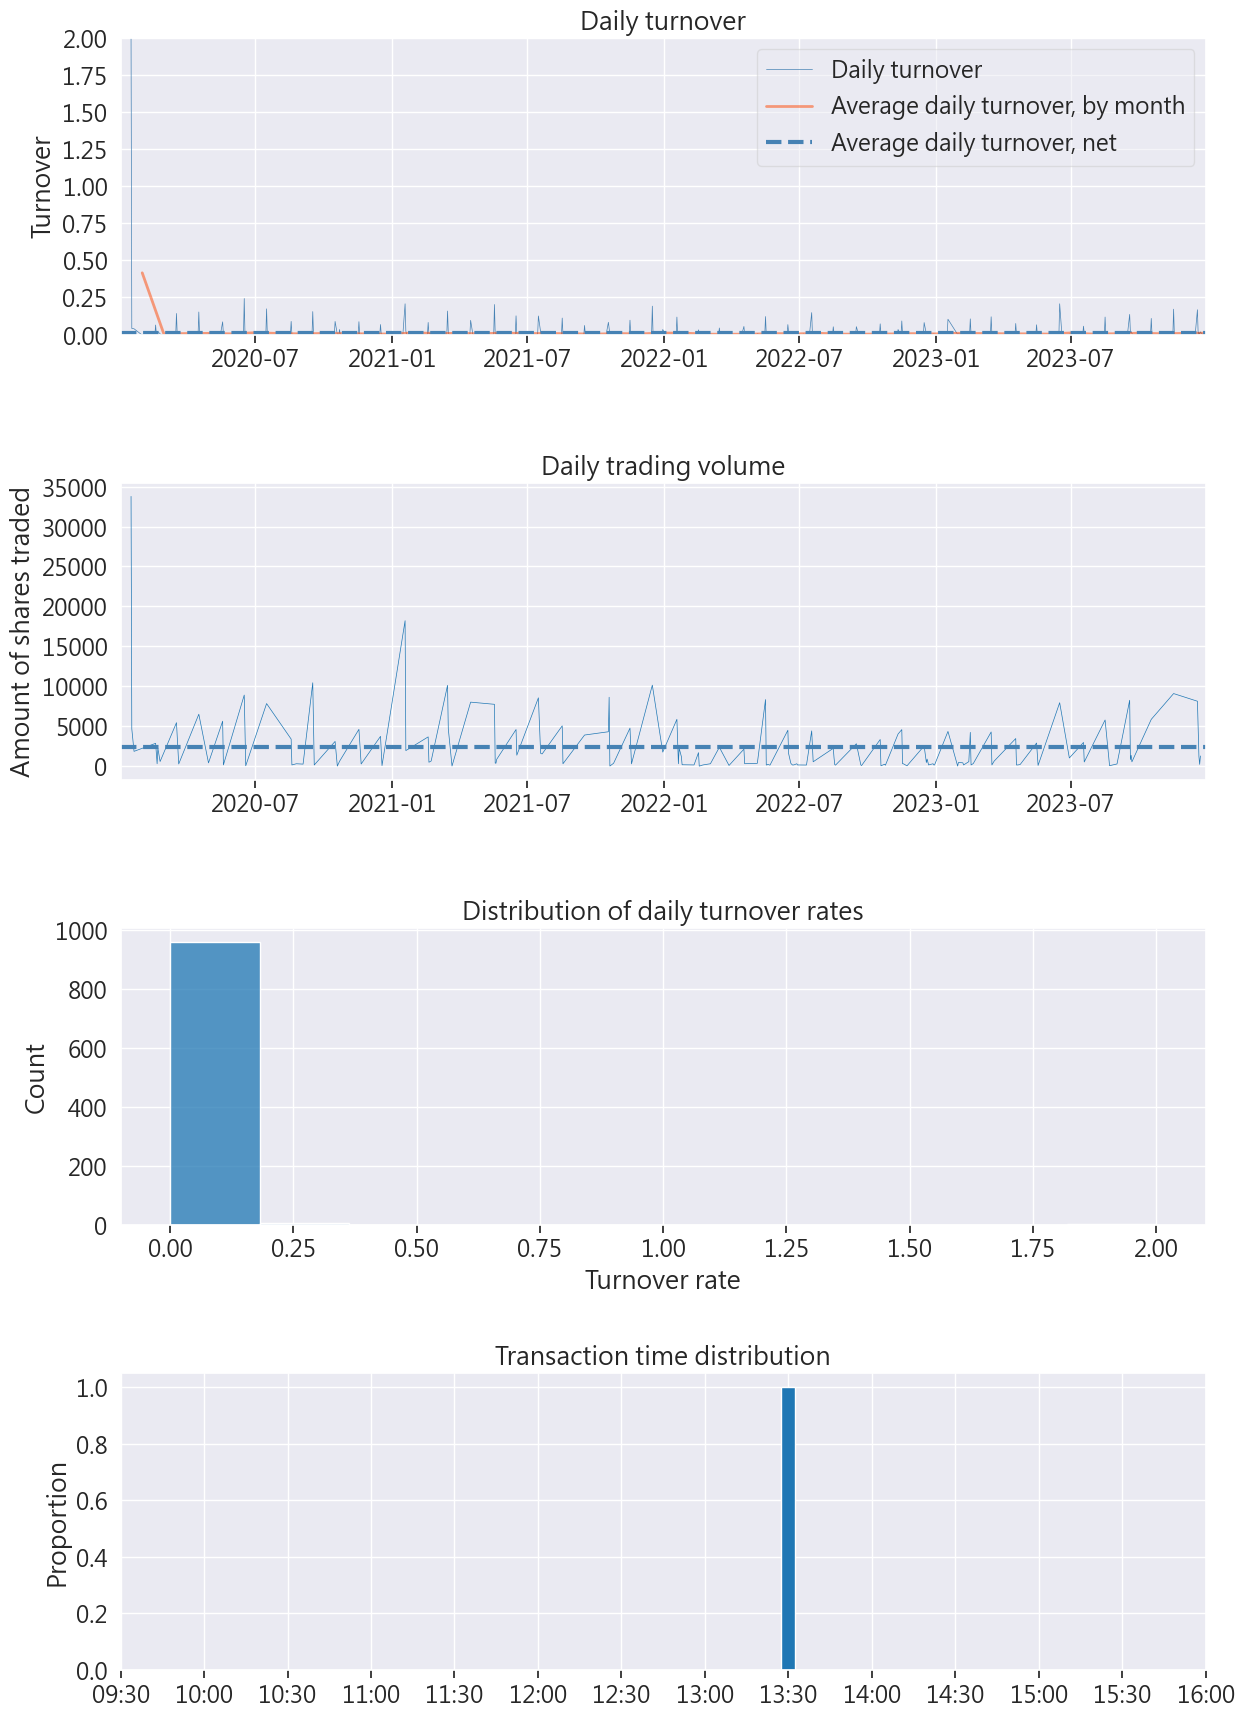

In [25]:
import pyfolio as pf

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns=returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark_rets
                         )